In [13]:
# testing model output with phase matched stimuli

import numpy
import jax.numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import os
import sys
numpy.random.seed(0)

from training.util_gabor import init_untrained_pars, create_gabor_filters_ori_map
from util import load_parameters
from parameters import (
    grid_pars,
    filter_pars,
    stimuli_pars,
    readout_pars,
    ssn_pars,
    conv_pars,
    training_pars,
    loss_pars,
    pretrain_pars # Setting pretraining to be true (pretrain_pars.is_on=True) should happen in parameters.py because w_sig depends on it
)

# Checking that pretrain_pars.is_on is on
if not pretrain_pars.is_on:
    raise ValueError('Set pretrain_pars.is_on to True in parameters.py to run training with pretraining!')


tc_ori_list = numpy.arange(0,180,2)
num_training = 10
final_folder_path = os.path.join('results','Apr10_v1')
########## Calculate and save gabor outputs ############
num_phases=4
i = 0
# Load orimap
orimap_filename = os.path.join(final_folder_path, f"orimap_{i}.npy")
orimap_loaded = numpy.load(orimap_filename)

# Calculate gaboor filters
untrained_pars = init_untrained_pars(grid_pars, stimuli_pars, filter_pars, ssn_pars, conv_pars, 
                loss_pars, training_pars, pretrain_pars, readout_pars, orimap_loaded= orimap_loaded)
results_filename = os.path.join(final_folder_path, f"results_{i}.csv")
trained_pars_stage1, trained_pars, offset_last = load_parameters(results_filename, iloc_ind = 0)

In [21]:
from analysis.analysis_functions import gabor_tuning
gabor_outputs = gabor_tuning(untrained_pars, ori_vec=tc_ori_list)


Time elapsed for gabor_output calculation: 61.19422769546509


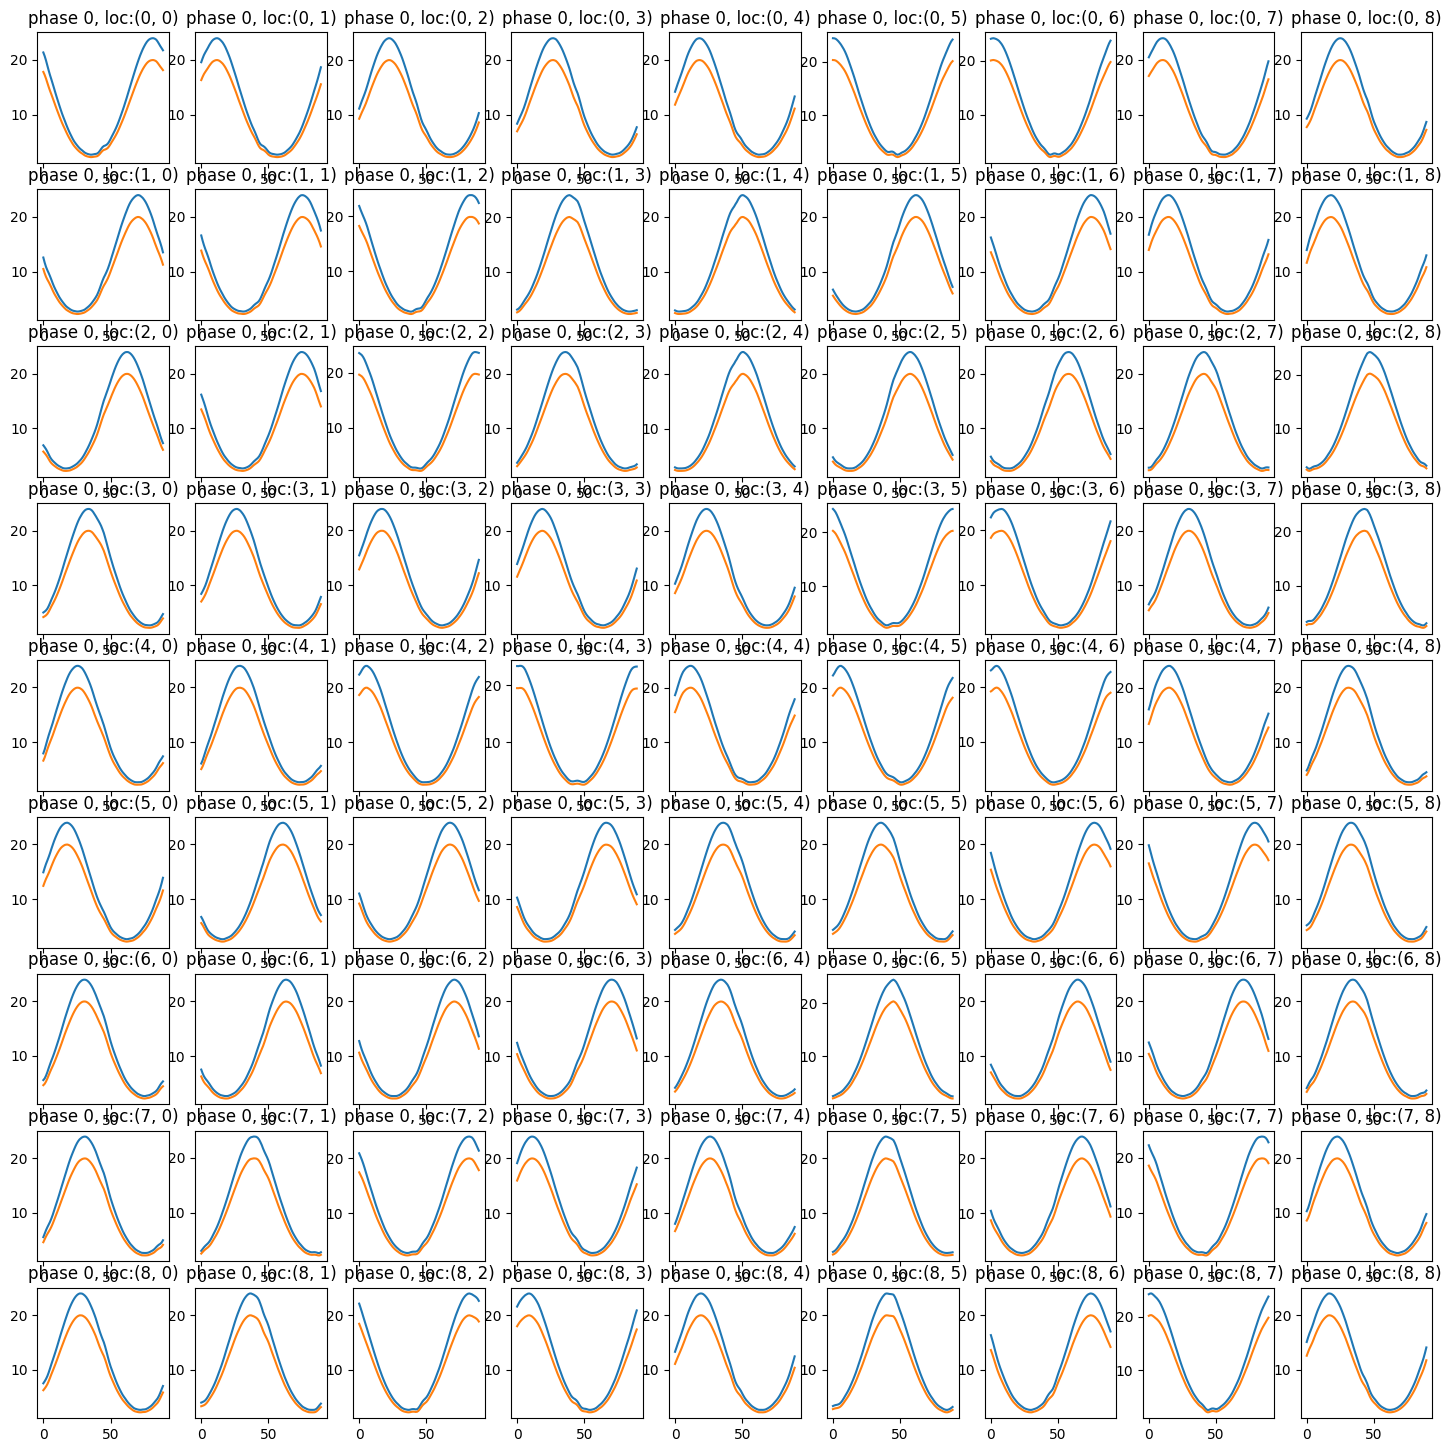

In [24]:
i=0
fig, axs = plt.subplots(9, 9, figsize=(2*9, 2*9))
phases = numpy.array([0,1,2,3])
phase_label = ['0', 'pi/2', 'pi', '3pi/2']
for loc1 in range(9):
    for loc2 in range(9):
        # E cells
        axs[loc1,loc2].plot(gabor_outputs[:,i,0,loc1+9*loc2])
        # I cells
        axs[loc1,loc2].plot(gabor_outputs[:,i,1,loc1+9*loc2])
        axs[loc1,loc2].set_title(f'phase {phase_label[i]}, loc:{loc1,loc2}')

In [27]:
# Calculating model response
from util import sep_exponentiate
from training.util_gabor import BW_image_jax_supp, BW_image_vmap
from training.SSN_classes import SSN_mid, SSN_sup
from training.model import vmap_evaluate_model_response_mid, vmap_evaluate_model_response

ori_vec=np.arange(0,180,2)
ref_ori_saved = float(untrained_pars.stimuli_pars.ref_ori)
if 'log_J_2x2_m' in trained_pars:
    J_2x2_m = sep_exponentiate(trained_pars['log_J_2x2_m'])
    J_2x2_s = sep_exponentiate(trained_pars['log_J_2x2_s'])
if 'J_2x2_m' in trained_pars:
    J_2x2_m = trained_pars['J_2x2_m']
    J_2x2_s = trained_pars['J_2x2_s']
if 'c_E' in trained_pars:
    c_E = trained_pars['c_E']
    c_I = trained_pars['c_I']
else:
    c_E = untrained_pars.ssn_pars.c_E
    c_I = untrained_pars.ssn_pars.c_I        
if 'log_f_E' in trained_pars:  
    f_E = np.exp(trained_pars['log_f_E'])
    f_I = np.exp(trained_pars['log_f_I'])
elif 'f_E' in trained_pars:
    f_E = trained_pars['f_E']
    f_I = trained_pars['f_I']
else:
    f_E = untrained_pars.ssn_pars.f_E
    f_I = untrained_pars.ssn_pars.f_I

ssn_mid=SSN_mid(ssn_pars=untrained_pars.ssn_pars, grid_pars=untrained_pars.grid_pars, J_2x2=J_2x2_m)

num_ori = len(ori_vec)
new_rows = []
x_map = untrained_pars.grid_pars.x_map
y_map = untrained_pars.grid_pars.y_map
ssn_pars = untrained_pars.ssn_pars
grid_size = x_map.shape[0]*x_map.shape[1]
responses_mid_phase_match = numpy.zeros((len(ori_vec),grid_size*ssn_pars.phases*2))
responses_sup_phase_match = numpy.zeros((len(ori_vec),grid_size*2))
for i in range(x_map.shape[0]):
    for j in range(x_map.shape[1]):
        for phase_ind in range(ssn_pars.phases):
            # Generate stimulus
            x0 = x_map[i, j]
            y0 = y_map[i, j]
            BW_image_jax_inp = BW_image_jax_supp(stimuli_pars, x0=x0, y0=y0, phase=phase_ind * np.pi/2, full_grating=True)
            x = BW_image_jax_inp[4]
            y = BW_image_jax_inp[5]
            alpha_channel = BW_image_jax_inp[6]
            mask = BW_image_jax_inp[7]
            train_data = BW_image_vmap(BW_image_jax_inp[0:4], x, y, alpha_channel, mask, ori_vec, np.zeros(num_ori))
            # Calculate model response for middle layer cells and save it to responses_mid_phase_match
            output_mid, _, _, _, _, responses_mid = vmap_evaluate_model_response_mid(ssn_mid, train_data, untrained_pars.conv_pars, c_E, c_I, untrained_pars.gabor_filters)
            mid_cell_ind_E = phase_ind*2*grid_size + i*x_map.shape[0]+j
            mid_cell_ind_I = phase_ind*2*grid_size + i*x_map.shape[0]+j+grid_size
            responses_mid_phase_match[:,mid_cell_ind_E]=responses_mid[:,mid_cell_ind_E] # E cell
            responses_mid_phase_match[:,mid_cell_ind_I]=responses_mid[:,mid_cell_ind_I] # I cell


In [29]:
print(responses_mid[:,0]+responses_mid[:,162]+responses_mid[:,324]+responses_mid[:,486])
print(output_mid[:,0])

[37.666496  38.44872   32.705143  35.711483  29.668686  31.923527
 27.215662  28.211002  25.403954  23.593544  23.222878  19.432434
 20.638517  16.89962   17.291105  16.193419  13.317221  14.171796
 12.490971  11.332502  11.18638    9.792372   9.46114    8.851623
  8.265384   8.048664   7.0829782  7.413045   7.055183   5.6982913
  6.6290555  6.412786   5.0539713  5.7782164  6.102368   5.1330104
  4.6761994  5.961953   5.9715843  4.986023   5.663724   6.4664645
  6.5945168  5.8295655  6.7521763  7.7274504  8.179919   8.117809
  7.343555   9.028888   9.580351  10.229717  11.235633  11.042524
 11.690615  13.839838  14.939663  14.849712  16.05143   18.513721
 20.37764   21.47639   21.967037  22.225212  22.546455  23.92729
 25.983103  27.799524  29.250761  30.238443  30.770414  32.033707
 35.044617  38.74482   42.383484  44.503555  43.72323   39.6842
 39.80261   46.189426  47.482014  41.40387   42.42299   47.77224
 42.216473  41.337635  45.54446   36.92525   42.816402  39.85354  ]
[37.66649

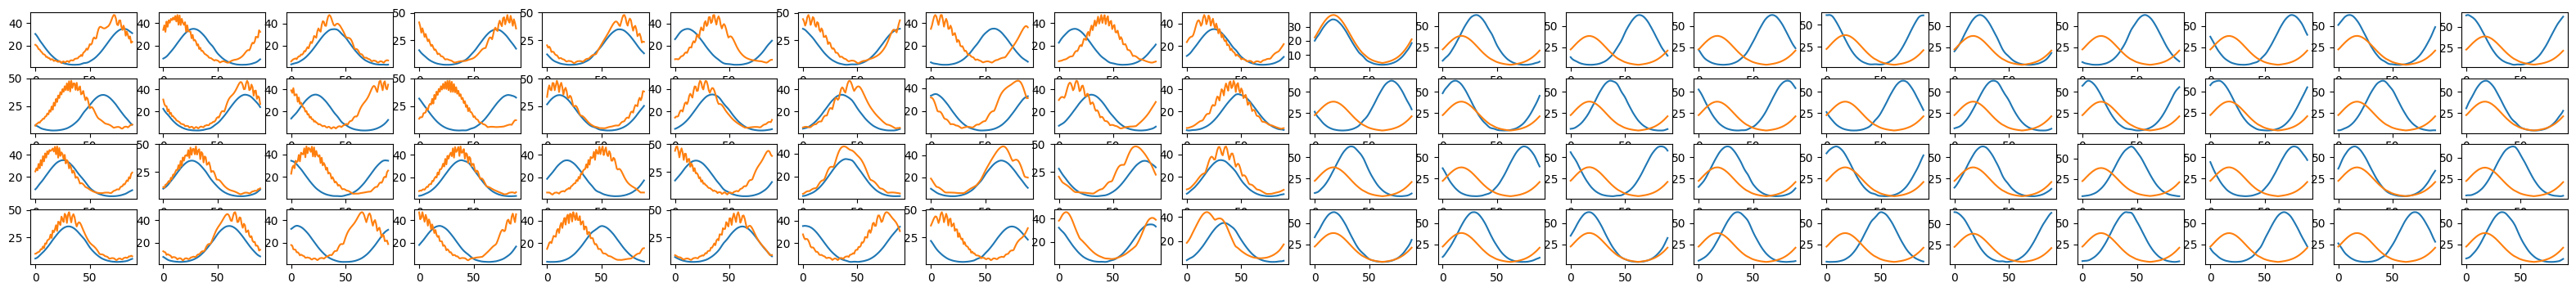

In [28]:
# Plot a few middle layer responses
fig, axs = plt.subplots(4, 20, figsize=(40,4))
for i in range(20):
    for phase_ind in range(4):
        mid_cell_ind = i*ssn_pars.phases*2+phase_ind*2
        axs[phase_ind,i].plot(responses_mid_phase_match[:,mid_cell_ind])
        axs[phase_ind,i].plot(output_mid[:,mid_cell_ind+1])
